In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from commons import (
    DATASET_CLEAN_LOCATION,
    DATASET_CLEAN_UNDERSAMPLING_LOCATION,
    MODEL_FOLDER,
    Datasets,
    ModelML,
    vectorize_and_split_dataset,
)
from numpy.typing import NDArray
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, learning_curve

In [2]:
df = pd.read_csv(DATASET_CLEAN_LOCATION)
df_undersampling = pd.read_csv(DATASET_CLEAN_UNDERSAMPLING_LOCATION)
df_bow = vectorize_and_split_dataset(df, CountVectorizer())
df_tfidf = vectorize_and_split_dataset(df, TfidfVectorizer())

In [3]:
PATH_MODEL_FOLDER = Path(MODEL_FOLDER)

with (PATH_MODEL_FOLDER / "nb_bow.pkl").open("rb") as f:
    nb_bow = pickle.load(f)

with (PATH_MODEL_FOLDER / "nb_tfidf.pkl").open("rb") as f:
    nb_tfidf = pickle.load(f)

with (PATH_MODEL_FOLDER / "lr_bow.pkl").open("rb") as f:
    lr_bow = pickle.load(f)

with (PATH_MODEL_FOLDER / "lr_tfidf.pkl").open("rb") as f:
    lr_tfidf = pickle.load(f)

In [4]:
### Valuto che non sono stato solo fortunato nello split

scores_nb_bow = cross_val_score(nb_bow, df_bow.X, df_bow.y, cv=5, scoring="accuracy")
print(f"Cross-validation accuracy nb_bow: {scores_nb_bow.mean():.4f} ± {scores_nb_bow.std():.4f}")
scores_nb_tfidf = cross_val_score(nb_tfidf, df_tfidf.X, df_tfidf.y, cv=5, scoring="accuracy")
print(f"Cross-validation accuracy nb_tfidf: {scores_nb_tfidf.mean():.4f} ± {scores_nb_tfidf.std():.4f}")
scores_lr_bow = cross_val_score(lr_bow, df_bow.X, df_bow.y, cv=5, scoring="accuracy")
print(f"Cross-validation accuracy lr_bow: {scores_lr_bow.mean():.4f} ± {scores_lr_bow.std():.4f}")
scores_lr_tfidf = cross_val_score(lr_tfidf, df_tfidf.X, df_tfidf.y, cv=5, scoring="accuracy")
print(f"Cross-validation accuracy lr_tfidf: {scores_lr_tfidf.mean():.4f} ± {scores_lr_tfidf.std():.4f}")

Cross-validation accuracy nb_bow: 0.9970 ± 0.0033
Cross-validation accuracy nb_tfidf: 0.9922 ± 0.0031
Cross-validation accuracy lr_bow: 0.9910 ± 0.0042
Cross-validation accuracy lr_tfidf: 0.9928 ± 0.0024


In [5]:
def print_cm_report(model: ModelML, dataset: Datasets, title: str) -> None:
    """
    Print the classification report and plot the confusion matrix for a given model.

    This function evaluates a trained classification model on the provided test dataset.
    It computes the predicted labels, displays a confusion matrix using Seaborn, and
    prints a detailed classification report including precision, recall, and F1-score.

    Args:
        model (ModelML): A trained classification model implementing the predict method.
        dataset (Datasets): A container with the test features and true labels.
        title (str): A title for the confusion matrix plot.

    Returns:
        None

    """
    y_pred = model.predict(dataset.X_t)
    cm = confusion_matrix(df_bow.y_t, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["English", "Italian"], yticklabels=["English", "Italian"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    print(classification_report(df_bow.y_t, y_pred, target_names=["English", "Italian"]))

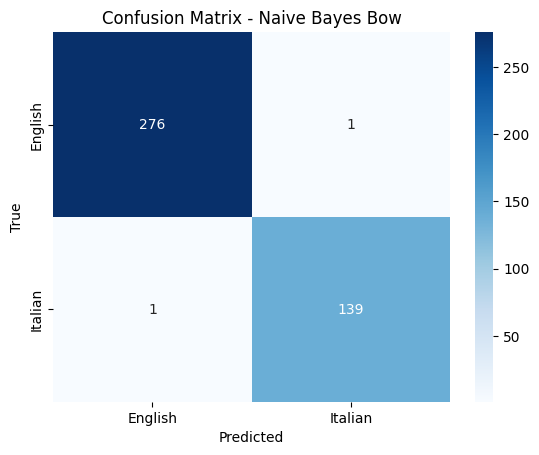

              precision    recall  f1-score   support

     English       1.00      1.00      1.00       277
     Italian       0.99      0.99      0.99       140

    accuracy                           1.00       417
   macro avg       0.99      0.99      0.99       417
weighted avg       1.00      1.00      1.00       417



In [6]:
print_cm_report(nb_bow, df_bow, "Naive Bayes Bow")

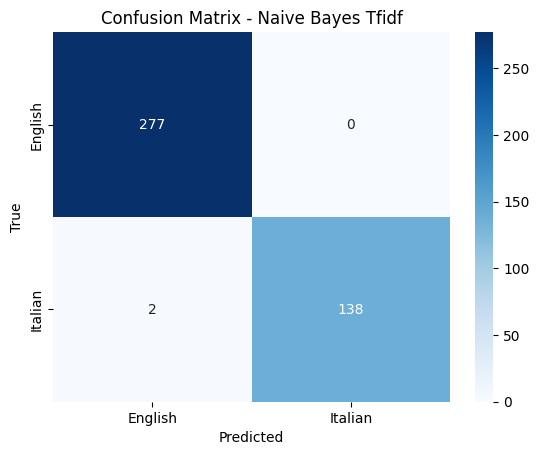

              precision    recall  f1-score   support

     English       0.99      1.00      1.00       277
     Italian       1.00      0.99      0.99       140

    accuracy                           1.00       417
   macro avg       1.00      0.99      0.99       417
weighted avg       1.00      1.00      1.00       417



In [7]:
print_cm_report(nb_tfidf, df_tfidf, "Naive Bayes Tfidf")

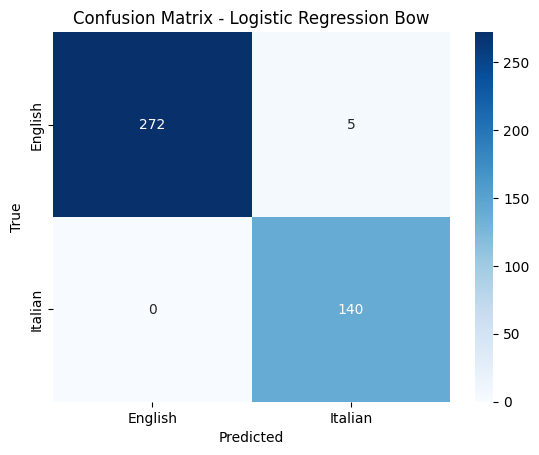

              precision    recall  f1-score   support

     English       1.00      0.98      0.99       277
     Italian       0.97      1.00      0.98       140

    accuracy                           0.99       417
   macro avg       0.98      0.99      0.99       417
weighted avg       0.99      0.99      0.99       417



In [8]:
print_cm_report(lr_bow, df_bow, "Logistic Regression Bow")

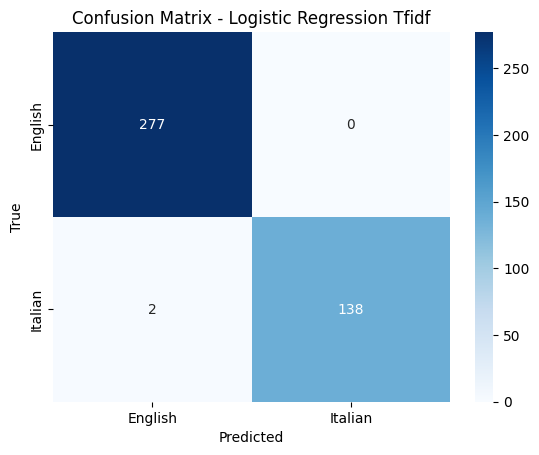

              precision    recall  f1-score   support

     English       0.99      1.00      1.00       277
     Italian       1.00      0.99      0.99       140

    accuracy                           1.00       417
   macro avg       1.00      0.99      0.99       417
weighted avg       1.00      1.00      1.00       417



In [9]:
print_cm_report(lr_tfidf, df_tfidf, "Logistic Regression Tfidf")

In [10]:
models = {
    "LogReg BoW": lr_bow,
    "LogReg TF-IDF": lr_tfidf,
    "NB BoW": nb_bow,
    "NB TF-IDF": nb_tfidf,
}

Xs = {
    "LogReg BoW": df_bow.X_t,
    "LogReg TF-IDF": df_tfidf.X_t,
    "NB BoW": df_bow.X_t,
    "NB TF-IDF": df_tfidf.X_t,
}


def build_auc_plot(models: dict[str, ModelML], Xs: dict[str, csr_matrix], y_t: NDArray[np.float64]) -> None:
    """
    Build ROC curves for multiple classification models.

    This function builds the ROC curves for a dictionary of trained classification models, each evaluated on
    its corresponding feature matrix. The function computes the AUC for each model and includes it in the plot legend.

    Args:
        models (dict[str, ModelML]): A dictionary of trained models keyed by their names.
        Xs (dict[str, csr_matrix]): A dictionary of test feature matrices corresponding to each model.
        y_t (NDArray[np.float64]): The true binary labels for the test set.

    Returns:
        None

    """
    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        y_probs = model.predict_proba(Xs[name])[:, 1]
        fpr, tpr, _ = roc_curve(y_t, y_probs)
        auc = roc_auc_score(y_t, y_probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.6f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - Classificatori")
    plt.legend(loc="lower right")
    plt.grid(visible=True)

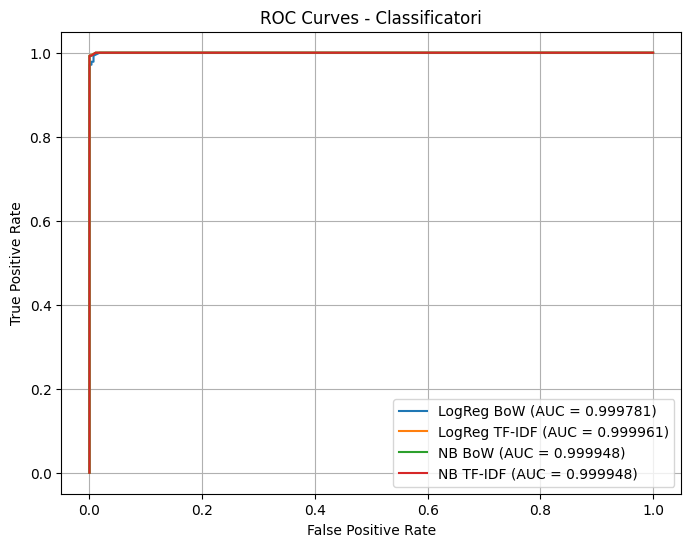

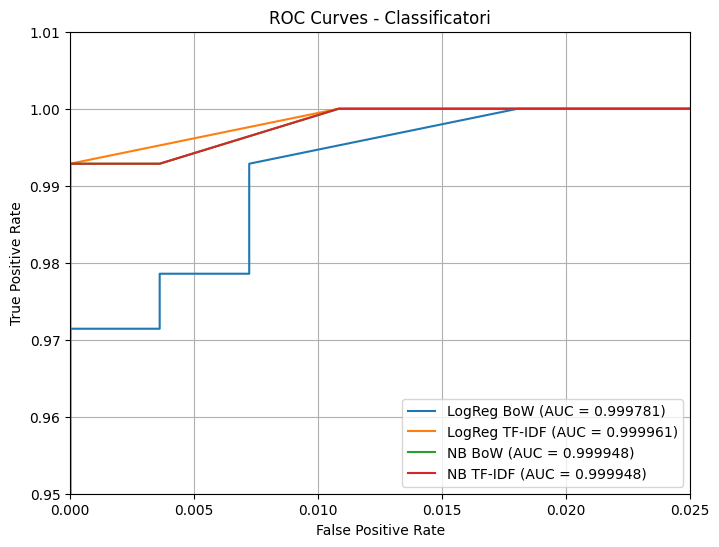

In [11]:
#Va bene df_bow.y_t tanto le label sono uguali per entrambi
build_auc_plot(models, Xs, df_bow.y_t)
plt.show()
build_auc_plot(models, Xs, df_bow.y_t)
plt.xlim(0.0, 0.025)
plt.ylim(0.950, 1.01)
plt.show()

In [ ]:
def plot_learning_curve(
    estimator: ModelML,
    X: csr_matrix,
    y: NDArray[np.float64],
    title: str,
    cv: int = 5,
    scoring: str = "accuracy",
) -> None:
    """
    Plot the learning curve of a machine learning model.

    This function evaluates the model performance on both the training and
    validation sets as the number of training samples increases. It helps
    to diagnose whether the model is underfitting, overfitting, or
    benefiting from more training data.

    Args:
        estimator (ModelML): The machine learning model to evaluate.
        X (csr_matrix): Feature matrix in sparse format.
        y (NDArray[np.float64]): Target labels.
        title (str): Title of the plot.
        cv (int, optional): Number of cross-validation folds. Defaults to 5.
        scoring (str, optional): Scoring metric to evaluate model performance. Defaults to "accuracy".

    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1,
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.plot(train_sizes, train_mean, label="Training score")
    plt.plot(train_sizes, val_mean, label="Validation score")
    plt.xlabel("Training set size")
    plt.ylabel(scoring.capitalize())
    plt.title(title)
    plt.legend()
    plt.grid(visible=True)
    plt.show()

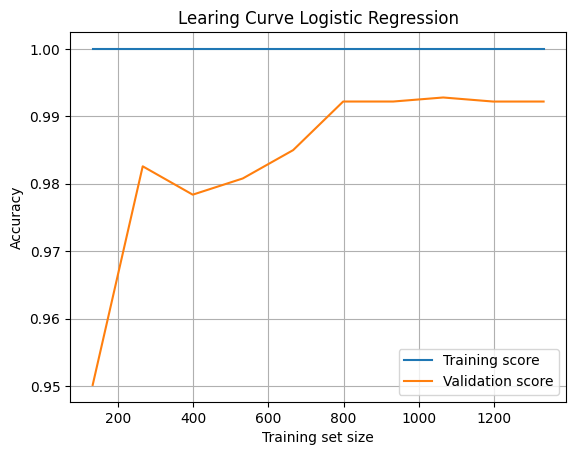

In [17]:
# Esempio con Logistic Regression e BoW
plot_learning_curve(lr_bow, df_bow.X, df_bow.y, "Learing Curve Logistic Regression")

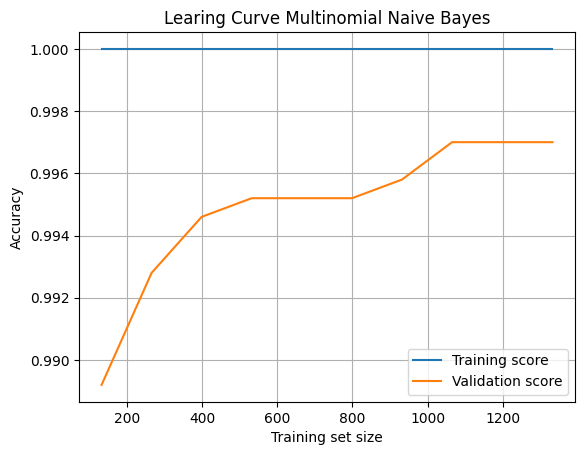

In [18]:
plot_learning_curve(nb_bow, df_bow.X, df_bow.y, "Learing Curve Multinomial Naive Bayes")